In [1]:
%load_ext jupyter_black

# extract transfer load

io is the input and output of information

io is part of both the extract and load process

python provides a io module

In [2]:
import io

# when working with io operations, some memory allocation happens
# after the operation is completed the file should be closed.
# fileIO may be used to write the contents to a text file.
file = io.FileIO("hello.txt", "w")
file.close()
# BytesIO might be used to download some data and write the contets of the download to a memory buffer
buffer = io.BytesIO()
buffer.close()

In [3]:
# this is an exampple of a context manager
# some classes or functions may offer the utility
# of a context manager to manage these type of operations
with io.BytesIO() as buffer:
    assert not buffer.closed

# once the NOTE SCOPE returns to the level from where the code was ran
# the context manager will close the file
assert buffer.closed

In [4]:
from contextlib import contextmanager

# below is the rough implementation of a context manager
# using the context manager decorator function
@contextmanager
def my_buffer():
    buffer = io.BytesIO()
    try:
        yield buffer
    finally:
        buffer.close()


with my_buffer() as b:
    assert not b.closed

assert b.closed

In [5]:
from typing import Callable


def my_dec(func: Callable):
    def wraps():
        return "hello " + func()

    return wraps


@my_dec
def hello():
    return "world"


hello()

'hello world'

In [6]:
import numpy as np

a = np.random.randint(0, 100, 100)

mask = (a > 25) & (a < 75)

i_was_inverted = ~mask != mask
assert all(i_was_inverted)

a[mask], a[~mask]

(array([38, 72, 33, 73, 47, 36, 38, 60, 48, 54, 40, 51, 35, 67, 46, 41, 67,
        29, 40, 30, 58, 35, 27, 30, 63, 52, 63, 65, 33, 71, 40, 67, 60, 68,
        47, 62, 58, 71, 50, 28, 38, 58, 65, 39, 27, 26, 35, 30, 52]),
 array([ 4,  7, 88,  2, 97,  3, 13,  3, 14, 13, 19, 77,  8, 19, 93,  7, 25,
        97, 17,  1, 77,  4, 20, 94, 79, 22,  0, 10, 82, 81, 16, 94, 20, 21,
        85, 85, 88, 24, 87, 20, 90, 20, 25, 89, 86, 83,  9, 95, 92, 82, 87]))

In [13]:
# the requests module
! pip install requests
import requests
help(requests.get)


# requests.get returns a response object
# which might look something like ...


class Response:
    status_code=200
    content = b"hello"
    raw:any = None
    def raise_for_status(self):
        if self.status_code != 200:
            raise Exception
def get():
    return Response()

r = get()
r.status_code
r.raise_for_status()    



Help on function get in module requests.api:

get(url, params=None, **kwargs)
    Sends a GET request.
    
    :param url: URL for the new :class:`Request` object.
    :param params: (optional) Dictionary, list of tuples or bytes to send
        in the query string for the :class:`Request`.
    :param \*\*kwargs: Optional arguments that ``request`` takes.
    :return: :class:`Response <Response>` object
    :rtype: requests.Response



In [14]:
import os
import shutil
from pathlib import Path
from typing import Literal
from datetime import datetime, date
# in the extraction function
# xarray will use cfgrib to read grib data
# for cfgrib to read the grib data it wil
# need to know the location of eccodes
# that can be set as an environmental vairable
ECCODES_DIR = "/usr/include/eccodes"
os.environ["ECCODES_DIR"] = ECCODES_DIR
import requests
import numpy as np
import xarray as xr


def download(url: str, folder: Path) -> Path:
    # true or false condition
    idx = url.endswith(".idx")
    # request to get a response from the server
    r = requests.get(url, stream=not idx)
    # in the event our request failed raise an http exception
    r.raise_for_status()
    # creating a local file name by splitting the url
    _, filename = r.url.rsplit("/", maxsplit=1)
    # creating New Path object to write the contents
    destination = folder / filename
    # using a context manager to open and close the file
    with destination.open("wb") as fdst:
        # the idx file is basicly just text so we can just write the content to the file object
        if idx:
            fdst.write(r.content)
        else:
            # the grib file can be kind of large, the shutil module
            # provides some utility for saving large files
            shutil.copyfileobj(r.raw, fdst)
    # last return the path object from the function so it can be read in the transfer stage
    return destination


def extract(target_date: date | datetime, path: Path) -> Path:
    url = f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/557ww/prod/557ww.{target_date:%Y%m%d}/GLOBAL.grib2.{target_date:%Y%m%d}00.0000"
    # first download the idx file
    download(url + ".idx", path)
    # the download the grib file
    file = download(url, path)
    # return the path object to the grib file
    return file


FilterLevel = Literal[
    "meanSea", "unknown", "heightAboveGroundLayer", "heightAboveSeaLayer", "hybrid"
]


def transfer(
    file: Path,
    type_of_level: FilterLevel = "heightAboveSeaLayer",
) -> xr.Dataset:
    """
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'unknown'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'hybrid'}
    filter_by_keys={'typeOfLevel': 'heightAboveSeaLayer'}
    """

    ds = xr.open_dataset(
        file,
        engine="cfgrib",
        backend_kwargs={"filter_by_keys": {"typeOfLevel": type_of_level}},
    )
    return ds.expand_dims({"validTime": [ds["valid_time"].values]}).drop(
        ["time", type_of_level, "step", "valid_time"]
    )


def load():
    ...


def main(start: date | datetime, path: Path = Path.cwd().parent / "data"):
    if not path.exists():
        path.mkdir()

    file = extract(start, path)
    # (file,) = (f for f in path.glob("*") if not f.suffix == ".idx")
    ds = transfer(file, "heightAboveGroundLayer")
    # load()
    return ds


if __name__ == "__main__":
    ds = main(date.today())
ds

<xarray.Dataset>
Dimensions:    (validTime: 1, latitude: 361, longitude: 720)
Coordinates:
  * validTime  (validTime) datetime64[ns] 2022-09-07
  * latitude   (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    turb       (validTime, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             57
    GRIB_centreDescription:  U.S. Air Force - Global Weather Center
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             U.S. Air Force - Global Weather Center
    history:                 2022-09-07T08:53 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
ds["turb"]

<xarray.DataArray 'turb' (validTime: 1, latitude: 361, longitude: 720)>
array([[[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. , 11.2, 11.2, ..., 11.2, 11.2,  0. ],
        [ 0. ,  3.2,  3.2, ...,  4. ,  3.2,  0. ],
        ...,
        [ 0. , 72.8, 72.8, ..., 72. , 72.8,  0. ],
        [ 0. , 87.2, 87.2, ..., 87.2, 87.2,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]]], dtype=float32)
Coordinates:
  * validTime  (validTime) datetime64[ns] 2022-09-07
  * latitude   (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Attributes:
    GRIB_paramId:                             260154
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         heightAboveGroundLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  720
    GRIB_Ny:                                  361
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           turb
    GRIB_gridDefinitionDescription:           Latitude/longitude. Also called...
    GRIB_iDirectionIncrementInDegrees:        0.5
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.5
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.5
    GRIB_missingValue:                        9999
    GRIB_name:                                Turbulence
    GRIB_shortName:                           turb
    GRIB_units:                               code table (4.208)
    long_name:                                Turbulence
    units:                                    code table (4.208)
    standard_name:                            unknown

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

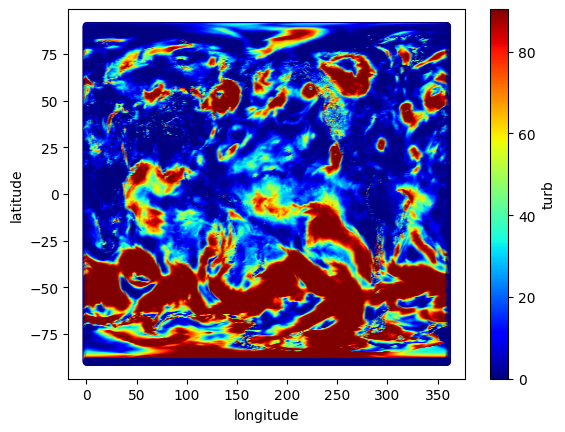

In [17]:
import matplotlib.pyplot as plt

ds.to_dataframe().reset_index().plot.scatter(
    x="longitude",
    y="latitude",
    cmap=plt.get_cmap("jet"),
    c="turb",
)

In [ ]:
import os
import sys
import shutil

import gzip
import zipfile
from pathlib import Path

text = f"""
os.path = {os.path.abspath(".")}
pathlib.Path.cwd() = {Path.cwd()}
sys.path = {sys.path}
"""
print(text)
dict(line.split("=", maxsplit=1) for line in text.split("\n") if line != "")


os.path = /home/leaver2000/afit/2022-09
pathlib.Path.cwd() = /home/leaver2000/afit/2022-09
sys.path = ['/home/leaver2000/afit/2022-09', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/opt/venv/lib/python3.10/site-packages', '/opt/venv/lib/python3.10/site-packages/IPython/extensions', '/home/leaver2000/.ipython']



{'os.path ': ' /home/leaver2000/afit/2022-09',
 'pathlib.Path.cwd() ': ' /home/leaver2000/afit/2022-09',
 'sys.path ': " ['/home/leaver2000/afit/2022-09', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/opt/venv/lib/python3.10/site-packages', '/opt/venv/lib/python3.10/site-packages/IPython/extensions', '/home/leaver2000/.ipython']"}

In [ ]:
cwd = Path.cwd()
assert cwd.is_dir() and not cwd.is_file()
# glob (/ɡlɑːb/) patterns specify sets of filenames with wildcard characters
# so in our working directory match all of the files or navigate to the parent and look for files ending with .py
# the glob method yields a generator function
tuple(cwd.glob("*")), tuple(cwd.parent.glob("*.py"))

((PosixPath('/home/leaver2000/afit/2022-09/lesson-2.2-dataclasses.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-2.0-io.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-3.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-1.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-2.3-enums.ipynb')),
 (PosixPath('/home/leaver2000/afit/app.py'),))

In [ ]:
import json

for file in Path.cwd().glob("*"):
    # the path object
    assert file.is_file()
    if ".ipynb" in file.suffixes:
        print(f"found a notebook {file}")
        # using the with key word will open the file as a context manager
        with file.open("r") as f:
            lines = f.readlines()
            print(f"it had {len(lines)} lines")
    # if not using the with key word
    # need to remember to close the file
    # otherwise we are loading tons of
    # unused data into memory
    f = file.open()
    f.close()

found a notebook /home/leaver2000/afit/2022-09/lesson-2.2-dataclasses.ipynb
it had 562 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-2.0-io.ipynb
it had 114 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-3.ipynb
it had 32 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-1.ipynb
it had 993 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-2.3-enums.ipynb
it had 447 lines


In [20]:
from collections.abc import MutableMapping


class D(MutableMapping):
    """
    Mapping that works like both a dict and a mutable object, i.e.
    d = D(foo='bar')
    and
    d.foo returns 'bar'
    """

    # ``__init__`` method required to create instance from class.
    def __init__(self, *args, **kwargs):
        """Use the object dict"""
        self.__dict__.update(*args, **kwargs)

    # The next five methods are requirements of the ABC.
    def __setitem__(self, key, value):
        self.__dict__[key] = value

    def __getitem__(self, key):
        return self.__dict__[key]

    def __delitem__(self, key):
        del self.__dict__[key]

    def __iter__(self):
        return iter(self.__dict__)

    def __len__(self):
        return len(self.__dict__)

    # The final two methods aren't required, but nice for demo purposes:
    def __str__(self):
        """returns simple dict representation of the mapping"""
        return str(self.__dict__)

    def __repr__(self):
        """echoes class, id, & reproducible representation in the REPL"""
        return "{}, D({})".format(super(D, self).__repr__(), self.__dict__)


assert {**D(foo="Bar")} == dict(D(foo="Bar"))